In [1]:
#imports
from preprocessing import prepare_dataset
from engine import model_eval

/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nop

## 1. Model Investigation

### 1.1 Template model

In [2]:
X_template, y_template = prepare_dataset(data_dir="data/",
                                      features="Standard")

In [ ]:
template_model = model_eval(X = X_template, y = y_template, model_type = "OLS")

### 1.2 Ridge regression model

In [2]:
X_improved, y_improved = prepare_dataset(data_dir="data/",
                                      features="Improved")

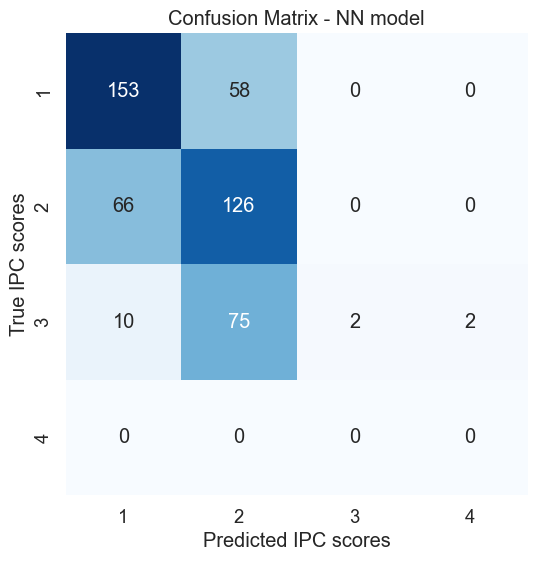

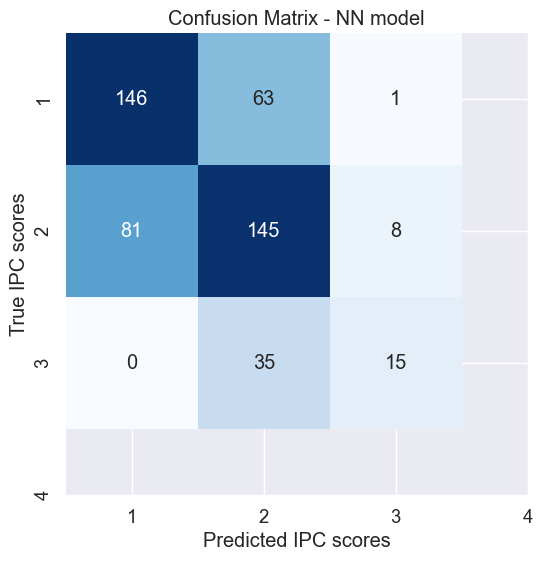

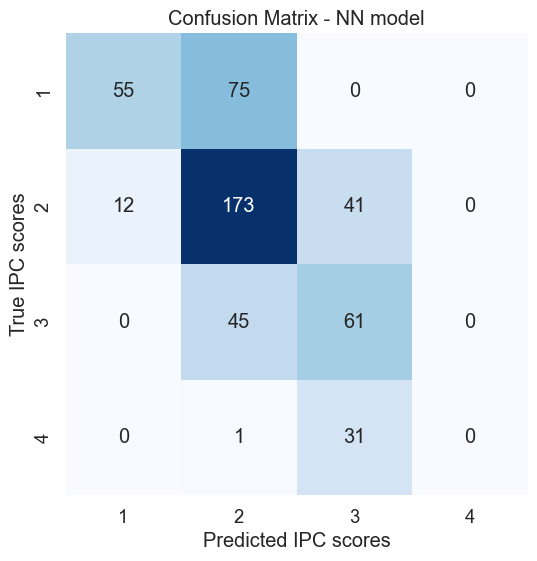

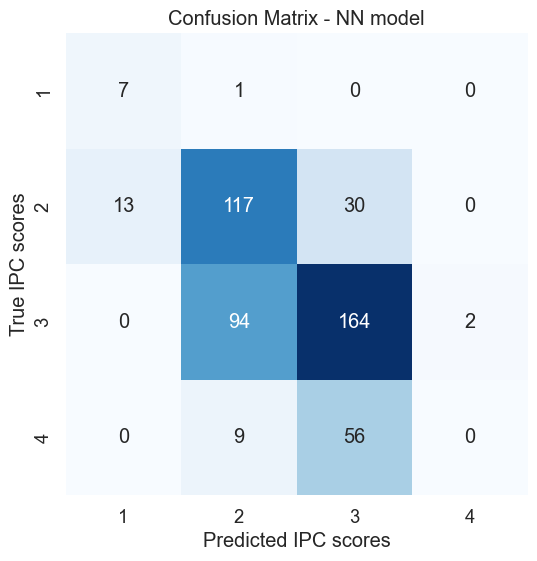

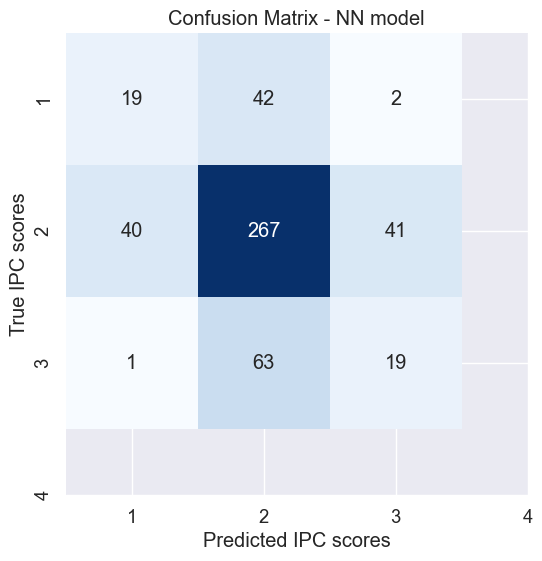

Mean MAE: 0.42
Mean R2: 0.45
Mean Accuracy: 59.47%
Mean Weighted F1: 0.569


In [3]:
Ridge_model = model_eval(X = X_improved, y = y_improved, model_type = "Ridge")

### 1.3 XGboost

### 1.4 NN default topics

### 1.5 Final NN

## 2. Article Utilization

## 3. Bias Reduction